


# Tutorial 2 -- Correlation and Filtering

<br></br>
<div class="author">Sheng (Ethan) LYU</div>

<div class="date">Date: 2024-02-23</div>



## Autocorrelation

$$
s(t) = A \cdot \cos(2 \pi \cdot f \cdot t + \phi).
$$

Text(0, 0.5, 'Correlation')

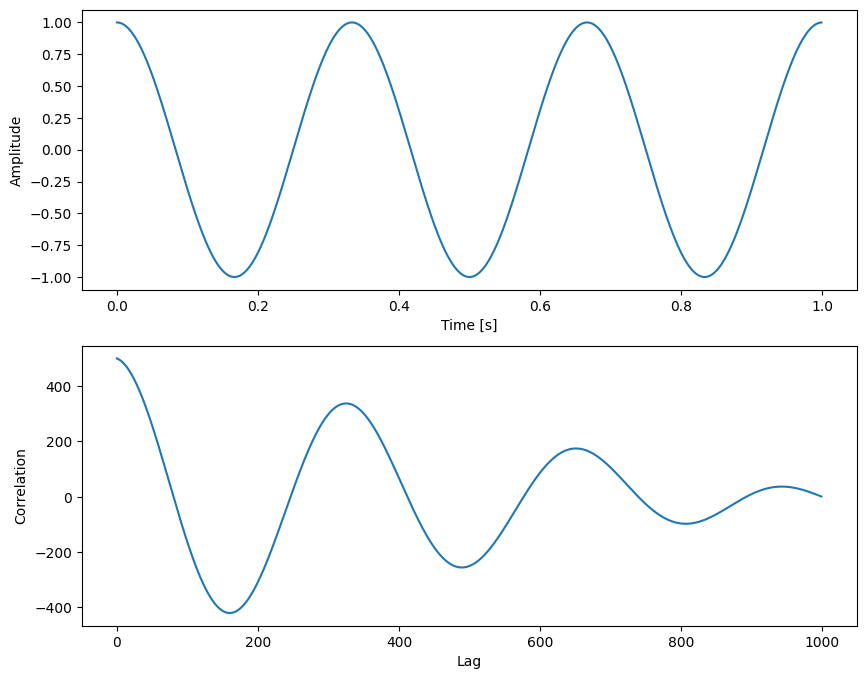

In [10]:
import numpy as np
from scipy.signal import correlate
from matplotlib import pyplot as plt

fs = 1000
t = np.arange(0, 1, 1/fs)
f0 = 3

s_t = np.cos(2*np.pi*f0*t)

# correlation
corr = correlate(s_t,s_t, mode="full")
lag = np.arange(-len(s_t)+1, len(s_t))
n = len(corr)
corr = corr[n//2:]
lag = lag[n//2:]


plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(t, s_t)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.subplot(2, 1, 2)
plt.plot(lag, corr)
plt.xlabel("Lag")
plt.ylabel("Correlation")

## Autocorrelation

In [7]:
def autocorrelation(x):
    result = correlate(x, x, mode='full') 
    result /= np.max(result) # normalize
    result = result[result.size // 2:]
    return result

## Understanding Autocorrelation 



1. **Shift** (Lag) the Signal: The original signal is shifted by a certain number of steps, creating a delayed version of itself. If the signal is shifted to the right (positive direction), the newly created empty spaces on the left are typically filled with zeros (padding).

2. **Multiply** Corresponding Elements: For each position, the value of the original signal is multiplied by the value of the delayed signal at that position.

3. **Summation**: The products obtained from the multiplication of corresponding elements are then summed up to get a single number. This sum represents the autocorrelation of the signal at that specific lag.

In [4]:
from IPython.display import Video
Video("./example_data/acf.mp4")

## Autocorrelation and periodicity

(array([20, 40, 60, 79]), array([0.2 , 0.4 , 0.6 , 0.79]))

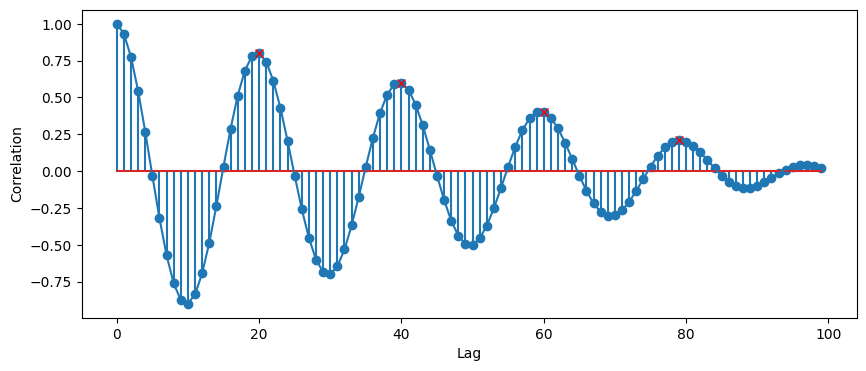

In [14]:
from scipy.signal import find_peaks
# Generate sample time series data
fs = 100
t = np.arange(0, 1, 1/fs)
f0 = 5
s_t = np.cos(2*np.pi*f0*t) 

plt.figure(figsize=(10, 4))
acf = autocorrelation(s_t)

x, _ = find_peaks(acf, prominence=0.1)


plt.stem(acf) 
plt.plot(acf)
plt.plot(x, acf[x], "x", color='red')

plt.xlabel("Lag")
plt.ylabel("Correlation")
x, x / fs

## Adding Windows

Sampling frequency: 20 Hz


Text(0, 0.5, 'Amplitude')

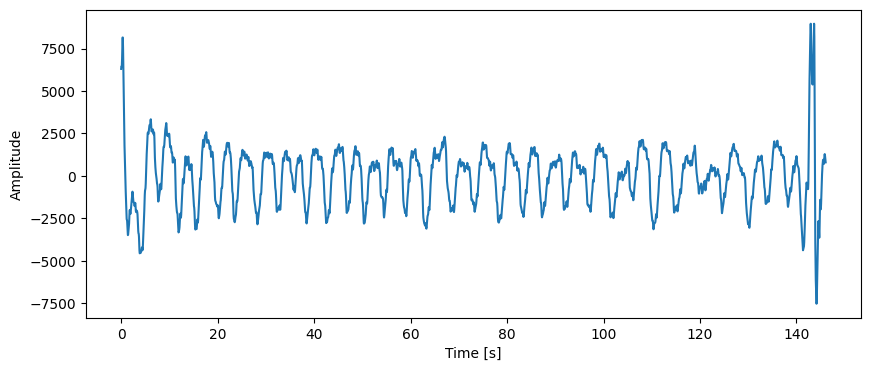

In [15]:
import pickle
br_p = "./example_data/br_0007800f30e4_2023-09-06_15-32-13.pkl"
with open(br_p, "rb") as f:
    br = pickle.load(f) 
br_v, fs = br["values"], br["fs"]
print(f"Sampling frequency: {fs} Hz")
br_ts = np.arange(0, len(br_v)/fs, 1/fs)
plt.figure(figsize=(10, 4))
plt.plot(br_ts, br_v)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude") 

Text(0, 0.5, 'Breathing Rate [bpm]')

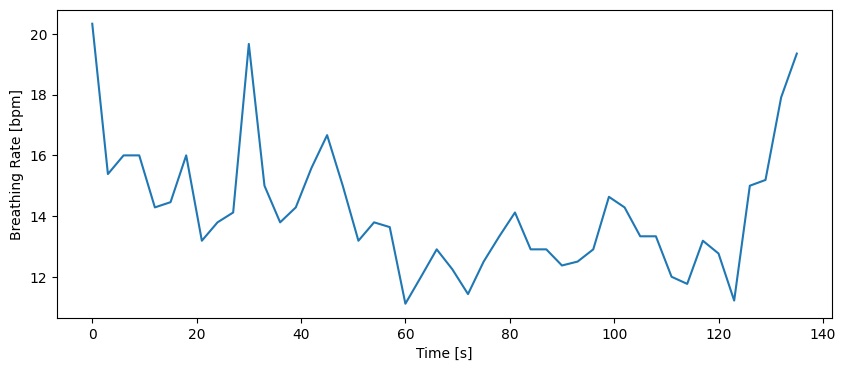

In [16]:
window_t = 10 # seconds
window_step = 3 # seconds
window_n = int(window_t * fs)

brs = []
timestamps = []
for i in range(0, len(br_v) - window_n, int(window_step * fs)):
    # print(f"Processing window {i} to {i+window_n}")
    window = br_v[i:i+window_n]
    acf = autocorrelation(window)
    x, _ = find_peaks(acf, prominence=0.05)
    br = fs / x[0] * 60 # convert to bpm
    t_s = i / fs
    
    brs.append(br) 
    timestamps.append(t_s)
plt.figure(figsize=(10, 4))
plt.plot(timestamps, brs)
plt.xlabel("Time [s]")
plt.ylabel("Breathing Rate [bpm]")
    

## Filtering

![Alt text](example_data/filtering.png)

### Frequency-selective Filter

![](./example_data/filters.png)

### Low Pass

Text(0, 0.5, 'Amplitude')

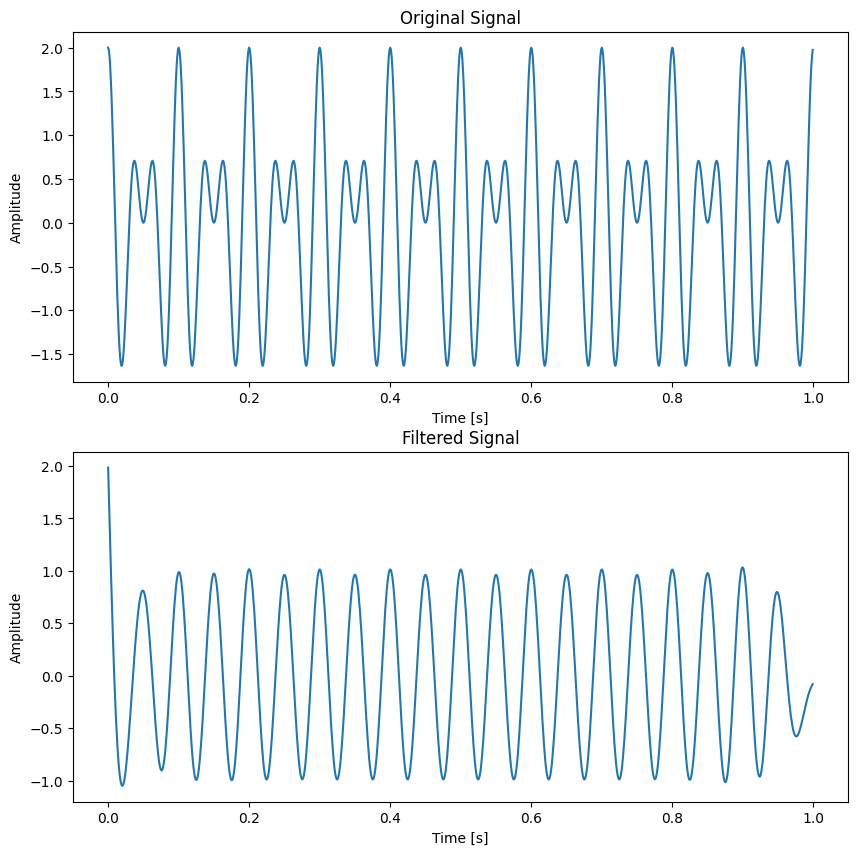

In [17]:
from scipy.signal import butter, sosfiltfilt
import numpy as np
from matplotlib import pyplot as plt

fs = 1000
t = np.arange(0,1,1/fs)
f1, f2 = 20, 30
s = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)

# filter
sos = butter(10, 25, fs=fs, btype="low", output="sos")
s_filt = sosfiltfilt(sos, s)

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(t, s)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2,1,2)
plt.plot(t, s_filt)
plt.title('Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

### `butter()`

![butter](example_data/butter.png)

- `N`: order of the filter (2-12)
- `Wn` and `fs`: cutoff frequency(ies) and sampling rate
  - If `fs` is not given, `Wn` should be normalized according to `fs/2`
  - `butter(10, cutoff_freq/(fs/2))` and `butter(10, cutoff_freq, fs=fs)` are equivalent
- `btype`: `{'lowpass', 'highpass', 'bandpass', 'bandstop'}`
- `output`: For general-purpose filtering, **we choose `sos`**

### Remove Noise

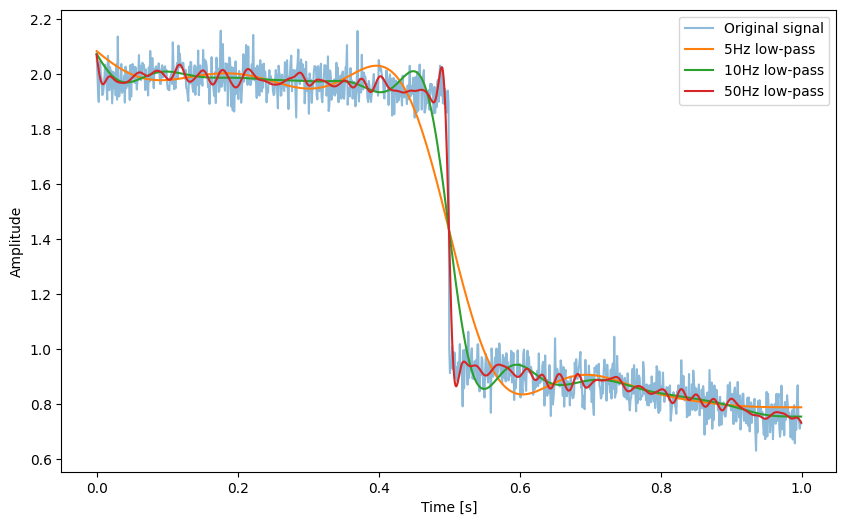

In [23]:
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt


rng = np.random.default_rng() # noise generator

fs = 1000 
t = np.arange(0, 1, 1/fs)
n = len(t)
x = 1 + (t < 0.5) - 0.25*t**2 + 0.05*rng.standard_normal(n)
plt.figure(figsize=(10, 6))
plt.plot(t, x, alpha=0.5, label='Original signal')

# 5 Hz low-pass
sos0 = butter(5, 5, fs=fs, btype="lp", output="sos")
y0 = sosfiltfilt(sos0, x)
# 10 Hz low-pass
sos1 = butter(5, 10, fs=fs, btype="lp", output="sos")
y1 = sosfiltfilt(sos1, x)
# 50 Hz low-pass
sos2 = butter(5, 50, fs=fs, btype="lp", output="sos")
y2 = sosfiltfilt(sos2, x)
# 100 Hz low-pass

plt.plot(t, y0, label='5Hz low-pass',)
plt.plot(t, y1, label='10Hz low-pass')
plt.plot(t, y2, label='50Hz low-pass')
# plt.plot(t, y3, label='100Hz low-pass')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

### Band-pass

Text(0, 0.5, 'Amplitude')

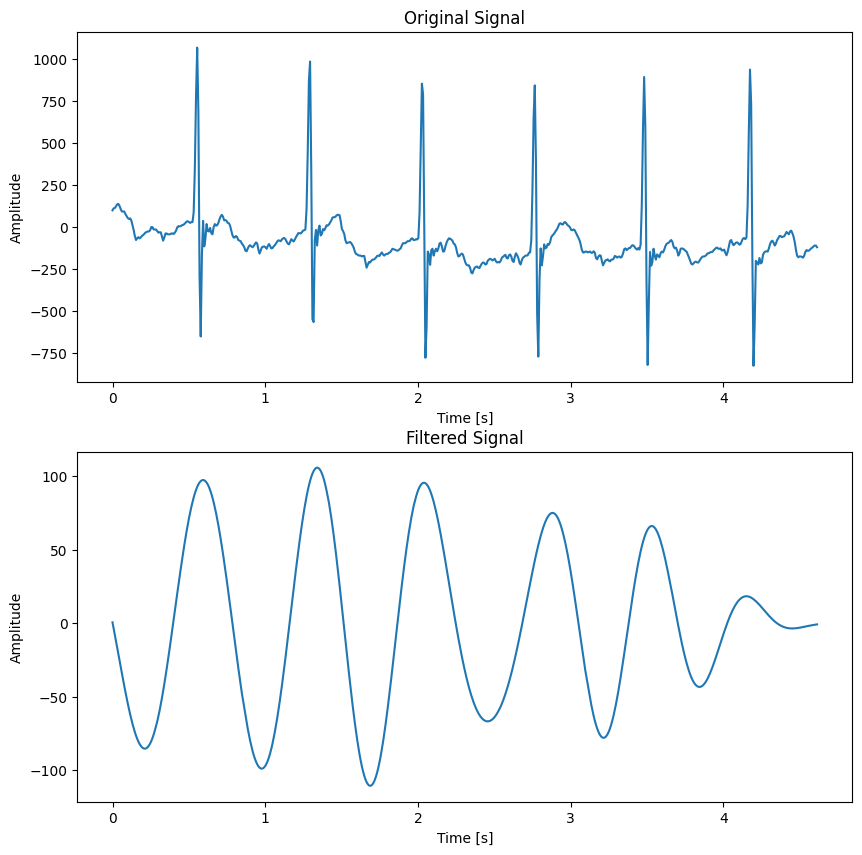

In [25]:
import numpy as np
from scipy.signal import sosfiltfilt, butter
import matplotlib.pyplot as plt
import pickle 
import os.path as osp


data_path = f"example_data/ecg.pickle"
with open(data_path, "rb") as f:
    data = pickle.load(f)
    ecg = data["values"]
    times = data["times"]
    fs = 1 / (times[1] - times[0])

sos = butter(5, [0.8, 2], fs=fs, btype="bp", output="sos")
ecg_filt = sosfiltfilt(sos, ecg)

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(times, ecg, label='Original signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.plot(times, ecg_filt, label='Filtered signal')
plt.title('Filtered Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


### Hampel Filter

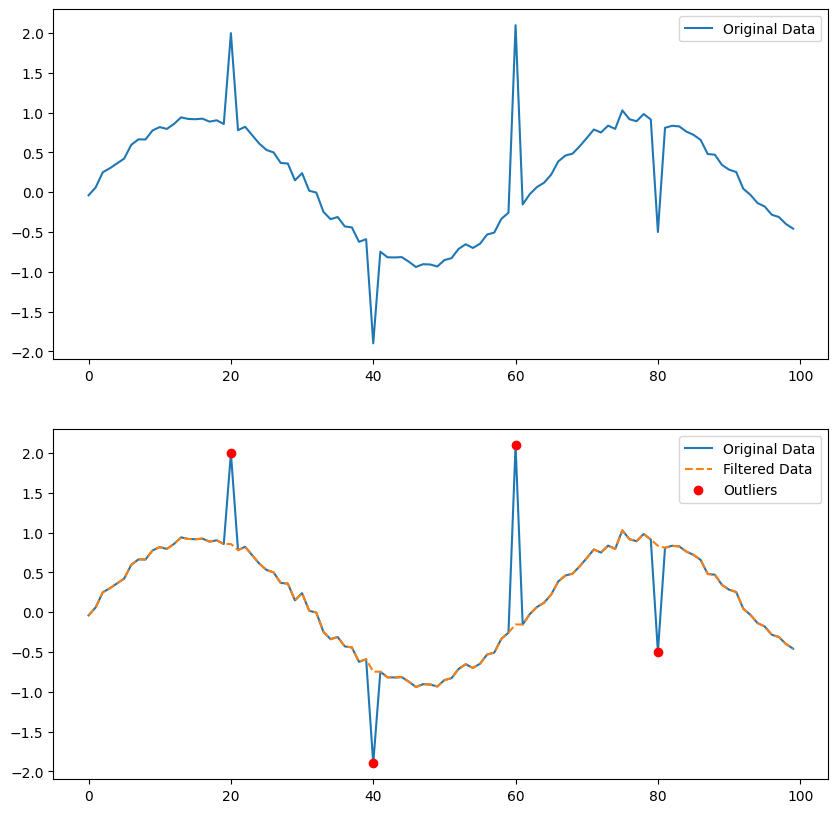

In [26]:
from hampel import hampel

data_p = f"example_data/outlier_data.pickle"

with open(data_p, "rb") as f:
    original_data = pickle.load(f)
    original_data = original_data["values"]

res = ham pel(original_data, window_size=10, n_sigma=3.0,)

plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(original_data, label='Original Data')
plt.legend()
plt.subplot(2,1,2)
plt.plot(original_data, label='Original Data')
plt.plot(res.filtered_data, label='Filtered Data', linestyle='--')
plt.plot(res.outlier_indices, original_data[res.outlier_indices], 'ro', label='Outliers')

plt.legend()

### Savitzky-Golay Filter

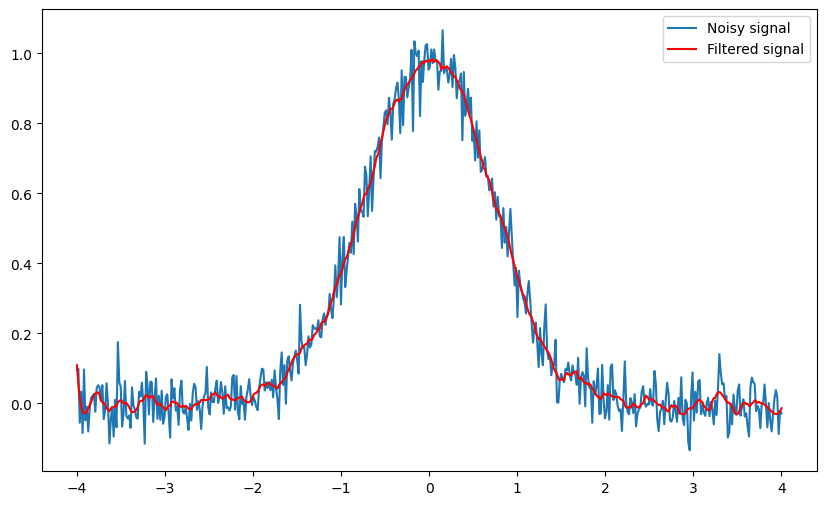

In [28]:
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt

t = np.linspace(-4, 4, 500)
original_signal = np.exp(-t ** 2)
s = original_signal + np.random.normal(0, 0.05, t.shape)

filtered = savgol_filter(s, 31, 4)
plt.figure(figsize=(10, 6))
plt.plot(t, s, label='Noisy signal')
# plt.plot(t, np.exp(-t ** 2), 'k', lw=1.5, label='Original signal')
plt.plot(t, filtered, 'r', label='Filtered signal')
plt.legend()
plt.show()

### How to submit

```
python check.py --uid <YOUR_UID>
```

- Test the docstring: check the format / test basic cases
- Zip your files
- **Upload the *.zip file to Moodle**.


## Your task

- Lab 3 (task 3): 2024-02-25 23:59:59
- Lab 4 (task 4): 2024-03-02 23:59:59
- Slip days apply

## Q/A